# Описание проекта

В этом проекте будем работать с базой данных StackOverflow — сервиса вопросов и ответов о программировании.
Данные хранят информацию о постах за 2008 год. Необходимо написать несколько SQL-запросов в Jupyter Notebook по конкретным заданиям.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`, с которой вы будете работать в проекте

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'ХХХ', # пароль
    'host': 'ХХХ',
    'port': ХХХ, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

Проверим, установилось ли соединение с базой. Напишем простенький запрос.

`sample_df` является pandas-датафреймом.

In [4]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

In [6]:
# напишите запрос
query = '''
SELECT DATE_TRUNC('month', p.creation_date)::date AS month_date, SUM(p.views_count) AS total_views
FROM stackoverflow.posts p
WHERE DATE_TRUNC('month', creation_date)::date BETWEEN '2008-01-01' AND '2008-12-31'
GROUP BY month_date
ORDER BY total_views DESC
'''
task_1 = pd.read_sql_query(query, con=engine) 
# выполните запрос

In [7]:
task_1

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?

Данные за первое полугодие отсутствуют. Далее наблюдаем стремительный рост кол-ва просмотров в течение 3 месяцев (с июля по сентябрь). С октября и до конца года происходит откат, кол-во просмотров падает.

**Эти данные свидетельствуют о том, что:**
   * Вероятно сервис запустился в середине 2008 года, поэтому данные за первое полугодие отсутствуют
   * Первые 3 месяца сервис активно набирал заинтересованную аудиторию. Возможно у сервиса была активная реклама для раскрутки и привлечения первых пользователей. 
   * Дальше начался отток аудитории
   
**Отток аудитории мог происходть по разным причинам. Приведем несколько гипотез:**
   * Это могло быть связано с уходом менее заинтересованной в услугах аудитории, которая откликнулась на рекламу, но не получила пользы от реальной услуги.
   * На рынке могли появиться конкуренты, которые предложили более интересную, проработанную услугу
   * У сервиса могли возникнуть какие-то технические сложности, мешающие комфортно его использовать. ** 

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

In [8]:
# напишите запрос
query = '''
SELECT u.display_name, COUNT(DISTINCT u.id)
FROM stackoverflow.users u
JOIN stackoverflow.posts p ON p.user_id=u.id
JOIN stackoverflow.post_types pt ON pt.id=p.post_type_id
WHERE (p.creation_date BETWEEN u.creation_date::date AND (u.creation_date::date + INTERVAL '1 month')) AND pt.type = 'Answer'
GROUP BY display_name
HAVING COUNT(p.id) > 100
ORDER BY u.display_name
'''
task_2 = pd.read_sql_query(query, con=engine) 
# выполните запрос

In [9]:
task_2

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
71,leppie,1
72,lomaxx,1
73,mattlant,1
74,paxdiablo,1


Какие аномалии наблюдаются в данных? О чём они говорят?

Всего результат показал 76 различных имен среди активных пользователей сервиса.
Вероятнее всего большая часть имен(никнеймов) должна быть уникальна. Проверим какая доля уникальных имен

In [10]:
(task_2.query('count == 1')['display_name'].count() / task_2['display_name'].count())*100

75.0

75% никнеймов активных пользователей являются уникальными - повторяются только 1 раз. 

Поищем аномалии среди имен, которые встречаются более 1 раза

In [11]:
task_2.query('count > 1').sort_values(by='count', ascending=False)

,display_name,count
10,Chris,29
43,Matt,29
14,Dan,21
62,Tom,19
33,Josh,16
40,Mark,16
48,Nick,16
7,Brian,15
54,Rob,14
21,Greg,12


Практически все повторяющиеся никнеймы являются довольно распространенными именами, поэтому не будем считать их аномалиями.

**Однако видим 3 повторения никнейма `jfs`, которое не является именем. Возможно проблема в том, что один пользователь несколько раз проходил регистрацию.**

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

In [12]:
# напишите запрос
query = '''
SELECT DATE_TRUNC('month', creation_date)::date AS month, COUNT(p.id)
FROM stackoverflow.posts p
WHERE p.user_id IN (SELECT u.id
       FROM stackoverflow.users u
       JOIN stackoverflow.posts p ON u.id=p.user_id
       WHERE u.creation_date::date BETWEEN '2008-09-01' AND '2008-09-30' AND
             p.creation_date::date BETWEEN '2008-12-01' AND '2008-12-31')
GROUP BY month
ORDER BY month DESC
'''

# выполните запрос

task_3 = pd.read_sql_query(query, con=engine) 


In [13]:
task_3

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

По условию необходимо было отфильтровать тех пользователей, которые зарегистрировались в сентября 2008 года. 
Соответсвенно раньше сентября они не могли написать посты.

Однако, в таблице с результатами мы видим 32 поста за август 2008 года. Причина может быть в некорректной информации о дате регистрации пользователей или же в некорректной установленной дате у постов. 

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

In [14]:
# напишите запрос
query = '''
SELECT p.user_id, p.creation_date, p.views_count,
       SUM(p.views_count) OVER(PARTITION BY p.user_id ORDER BY p.creation_date)
FROM  stackoverflow.posts p
ORDER BY p.user_id, p.creation_date
'''

# выполните запрос

task_4 = pd.read_sql_query(query, con=engine) 


In [15]:
task_4.head(10)

,user_id,creation_date,views_count,sum
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
5,1,2008-08-04 08:04:42,0,616509
6,1,2008-08-10 08:28:52,0,616509
7,1,2008-08-11 19:23:47,0,616509
8,1,2008-08-12 00:30:43,0,616509
9,1,2008-08-12 04:59:35,72431,688940


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

In [16]:
# напишите запрос
query = '''
WITH aug_posts AS
(SELECT DISTINCT p.user_id, DATE_TRUNC('day', p.creation_date)::date AS day, 
       COUNT(p.id) AS cnt
FROM stackoverflow.posts p
WHERE p.user_id IN (SELECT p.user_id 
       FROM stackoverflow.posts p 
       WHERE p.creation_date::date BETWEEN '2008-08-01' AND '2008-08-31'
       GROUP BY p.user_id
       HAVING COUNT(p.id) > 120)
GROUP BY 1,2)

SELECT DISTINCT user_id, AVG(cnt) OVER(PARTITION BY user_id) AS avg_daily 
FROM aug_posts
WHERE day::date BETWEEN '2008-08-01' AND '2008-08-31'
ORDER BY avg_daily   
       
'''

task_5 = pd.read_sql_query(query, con=engine) 

# выполните запрос

In [17]:
task_5

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

In [18]:
# напишите запрос
query = '''
WITH active_days AS 
(SELECT user_id, COUNT(DISTINCT DATE_TRUNC('day', creation_date)::date) AS act_days
FROM stackoverflow.posts 
WHERE creation_date::date BETWEEN '2008-12-01' AND '2008-12-07'
GROUP BY 1
HAVING COUNT(id) >= 1)

SELECT ROUND(AVG(act_days)) AS avg_active_days
FROM active_days
'''

# выполните запрос
task_6 = pd.read_sql_query(query, con=engine) 


In [19]:
task_6

,avg_active_days
0,2.0


Проанализируйте итоговую таблицу — какие выводы можно сделать?

В среднем пользователи были активны 2 из 7 дней в первую неделю декабря 2008 года.

Это неплохой результат. Значит участники регулярно возвращаются к платформе. 
Далее будут интересно изучить портрет пользователей, которые каждый день пользуются услугами платформы, и наоборот, тех кто редк на ней появляется. 
Это позволит в дальнейшем работать над укреплением этого показателя

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

In [20]:
#to_char( creation_date, 'Month')

In [21]:
# напишите запрос
query = '''
SELECT user_id, creation_date,
        LAG(to_char(creation_date, 'Month'), 2, NULL) OVER(PARTITION BY user_id ORDER BY creation_date)
FROM stackoverflow.posts 
ORDER BY user_id, creation_date
'''

# выполните запрос
task_7 = pd.read_sql_query(query, con=engine) 


In [22]:
task_7

,user_id,creation_date,lag
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

In [23]:
# напишите запрос
query = '''
WITH profile AS (
 
SELECT id, 
       cohort_dt, 
       COUNT(id) over(PARTITION BY cohort_dt) AS cohort_users_cnt
FROM (SELECT u.id AS id,
        MIN(DATE_TRUNC('month', p.creation_date)) AS cohort_dt  
      FROM stackoverflow.users u
      JOIN stackoverflow.posts p ON u.id = p.user_id
      GROUP BY 1) t
GROUP BY id, cohort_dt),

sessions AS 
(SELECT user_id,
        DATE_TRUNC('month', creation_date)::date AS session_date
FROM stackoverflow.posts  
GROUP BY 1,
         2)   

SELECT p.cohort_dt,
       s.session_date,
       COUNT(id) AS users_cnt, 
       cohort_users_cnt,
       ROUND(COUNT(DISTINCT id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM profile p
JOIN sessions s ON p.id = s.user_id
GROUP BY 1,
         2,
         4; 

'''

# выполните запрос
task_8 = pd.read_sql_query(query, con=engine) 


In [24]:
task_8

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

In [25]:
# постройте тепловую карту Retention Rate

In [26]:
import seaborn as sns
import pandas as pd
import numpy as np

Text(0.5, 15.0, 'Лайфтайм')

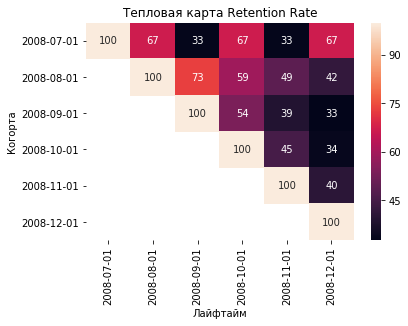

In [36]:
retention = task_8.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]
# Default heatmap

retention_rate_hm = sns.heatmap(retention, annot=True, fmt='.0f', annot_kws={"size": 10})

# Название графика и осей
retention_rate_hm.set_title("Тепловая карта Retention Rate")
retention_rate_hm.set_ylabel("Когорта")
retention_rate_hm.set_xlabel('Лайфтайм')


Retention Rate у первой когорты (июльская) скачет. То есть пользователи из первой когорты нестабильно возвращались к написанию постов на сервисе.
При этом все остальные когорты, как и происходит в большинстве случаев, потихоньку уходили из сервиса. С каждым месяцем возвращалось все меньше и меньше пользователей.


**С чем связана особенность первой когорты?**
В итоговой таблице видим, что в первую когорту вошли только лишь 3 пользователя, так как сервис только запустился. 
Поэтому приход/уход каждого пользователя из первой когорты дает слишком сильное изменение показателя. 

Для дальнейшего анализа первую когорту можно отбросить из-за маленькой выборки.

<hr style="border: 2px solid green;" />

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

In [29]:
# напишите запрос
query = '''
WITH cnt AS 
(SELECT DATE_TRUNC('month', creation_date)::date AS creation_month,
       COUNT(id) posts_count
FROM stackoverflow.posts
WHERE creation_date::date BETWEEN '2008-09-01' AND '2008-12-31'
GROUP BY creation_month),

prev_cnt AS 
(SELECT EXTRACT('month' from creation_month)::integer creation_month, posts_count, 
        LAG(posts_count) OVER(ORDER BY creation_month) previous_count
FROM cnt)

SELECT creation_month, posts_count,
       ROUND((((posts_count::numeric - previous_count::numeric) / previous_count)*100), 2) AS percentage
FROM prev_cnt
'''
task_9 = pd.read_sql_query(query, con=engine) 

# выполните запрос

In [30]:
task_9

,creation_month,posts_count,percentage
0,9,70371,NaN
1,10,63102,-10.33
2,11,46975,-25.56
3,12,44592,-5.07


Постройте круговую диаграмму с количеством постов по месяцам.

Text(0.5, 1.0, 'Количество постов по месяцам в 2008 году')

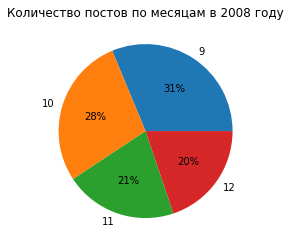

In [31]:
# постройте круговую диаграмму с количеством постов по месяцам
# загружаем библиотеку
import matplotlib.pyplot as plt


# Создаем круговую диаграмму
plt.pie(task_9['posts_count'], labels = task_9['creation_month'], autopct='%.0f%%')
plt.title("Количество постов по месяцам в 2008 году")


# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

In [32]:
# напишите запрос
query = '''

SELECT EXTRACT('week' from creation_date)::integer AS week_creation, MAX(creation_date)
FROM stackoverflow.posts
WHERE user_id IN (SELECT user_id
FROM stackoverflow.posts 
GROUP BY user_id
ORDER BY COUNT(id) DESC
LIMIT 1) AND
DATE_TRUNC('month', creation_date) = '2008-10-01'
GROUP BY week_creation

'''
task_10 = pd.read_sql_query(query, con=engine) 


# выполните запрос

In [33]:
task_10

,week_creation,max
0,40,2008-10-05 09:00:58
1,41,2008-10-12 21:22:23
2,42,2008-10-19 06:49:30
3,43,2008-10-26 21:44:36
4,44,2008-10-31 22:16:01
